# ML Application Example
## Regression

The task of this example is to implement a complete Data Driven pipeline (load, data-analysis, visualisation, model selection and optimization, prediction) on a specific Dataset. In this example the challenge is to perform a regression with different models to find the most accurate prediction.  


## Dataset 
The notebook will upload a public available dataset: https://archive.ics.uci.edu/ml/datasets/energy+efficiency
<blockquote>
  <b>Source:</b>
    The dataset was created by Angeliki Xifara (angxifara@gmail.com, Civil/Structural Engineer) and was processed by Athanasios    
    Tsanas (tsanasthanasis@gmail.com, Oxford Centre for Industrial and Applied Mathematics, University of Oxford, UK).
    <br/>
    <b>Data Set Information:</b>
    The author of the dataset perform energy analysis using 12 different building shapes simulated in Ecotect. The buildings differ with 
    respect to the glazing area, the glazing area distribution, and the orientation, amongst other parameters. They simulate various 
    settings as functions of the afore-mentioned characteristics to obtain 768 building shapes. The dataset comprises 768 samples and 8 
    features, aiming to predict two real valued responses. It can also be used as a multi-class classification problem if the response 
    is rounded to the nearest integer.
    <br/>
    <b>Attribute Information:</b>
    The dataset contains eight attributes (or features, denoted by X1...X8) and two responses (or outcomes, denoted by y1 and y2). The 
    aim is to use the eight features to predict each of the two responses.
    <br/>
    <b>Specifically:</b>
    <br/>
    <code><br/> X1 :: Relative Compactness <br/> X2 :: Surface Area <br/> X3 :: Wall Area <br/> X4 :: Roof Area </code>
    <code><br/> X5 :: Overall Height <br/> X6 :: Orientation <br/> X7 :: Glazing Area <br/> X8 :: Glazing Area Distribution </code>
    <code><br/> y1 :: Heating Load <br/> y2 :: Cooling Load </code>
    <br/>
</blockquote>

In [4]:
# algebra
import numpy as np
# data structure
import pandas as pd
# data visualization
import matplotlib.pylab as plt
import seaborn as sns
#file handling
from pathlib import Path


# Data load
The process consist in downloading the data if needed, loading the data as a Pandas dataframe

In [7]:
    
filename  = "ENB2012_data.xlsx"
separator = ';'
columns   = None

#if the dataset is not already in the working dir, it will download
my_file = Path(filename)
if not my_file.is_file():
  print("Downloading dataset")
  !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx


In [9]:
#function to semplificate the load of dataset, in case it is a csv, tsv or excel file
#output is a pandas dataframe 
def load_csv(filename,separator,columns):
    
    try:
    
        csv_table = pd.read_csv(filename,sep=separator,names=columns)
    
    except:
        
        csv_table = pd.read_excel(filename,names=columns)
    print("n. samples: {}".format(csv_table.shape[0]))
    print("n. columns: {}".format(csv_table.shape[1]))

    return csv_table #.dropna()

data = load_csv(filename,separator,columns)

n. samples: 768
n. columns: 10


# Data Analysis and Visualization
In this section confidence with the data is gained, data are plotted and cleaned

In [4]:
#How does the dataset look like? 
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [10]:
#Name of all columns
print(data.columns.values)

['X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X8' 'Y1' 'Y2']


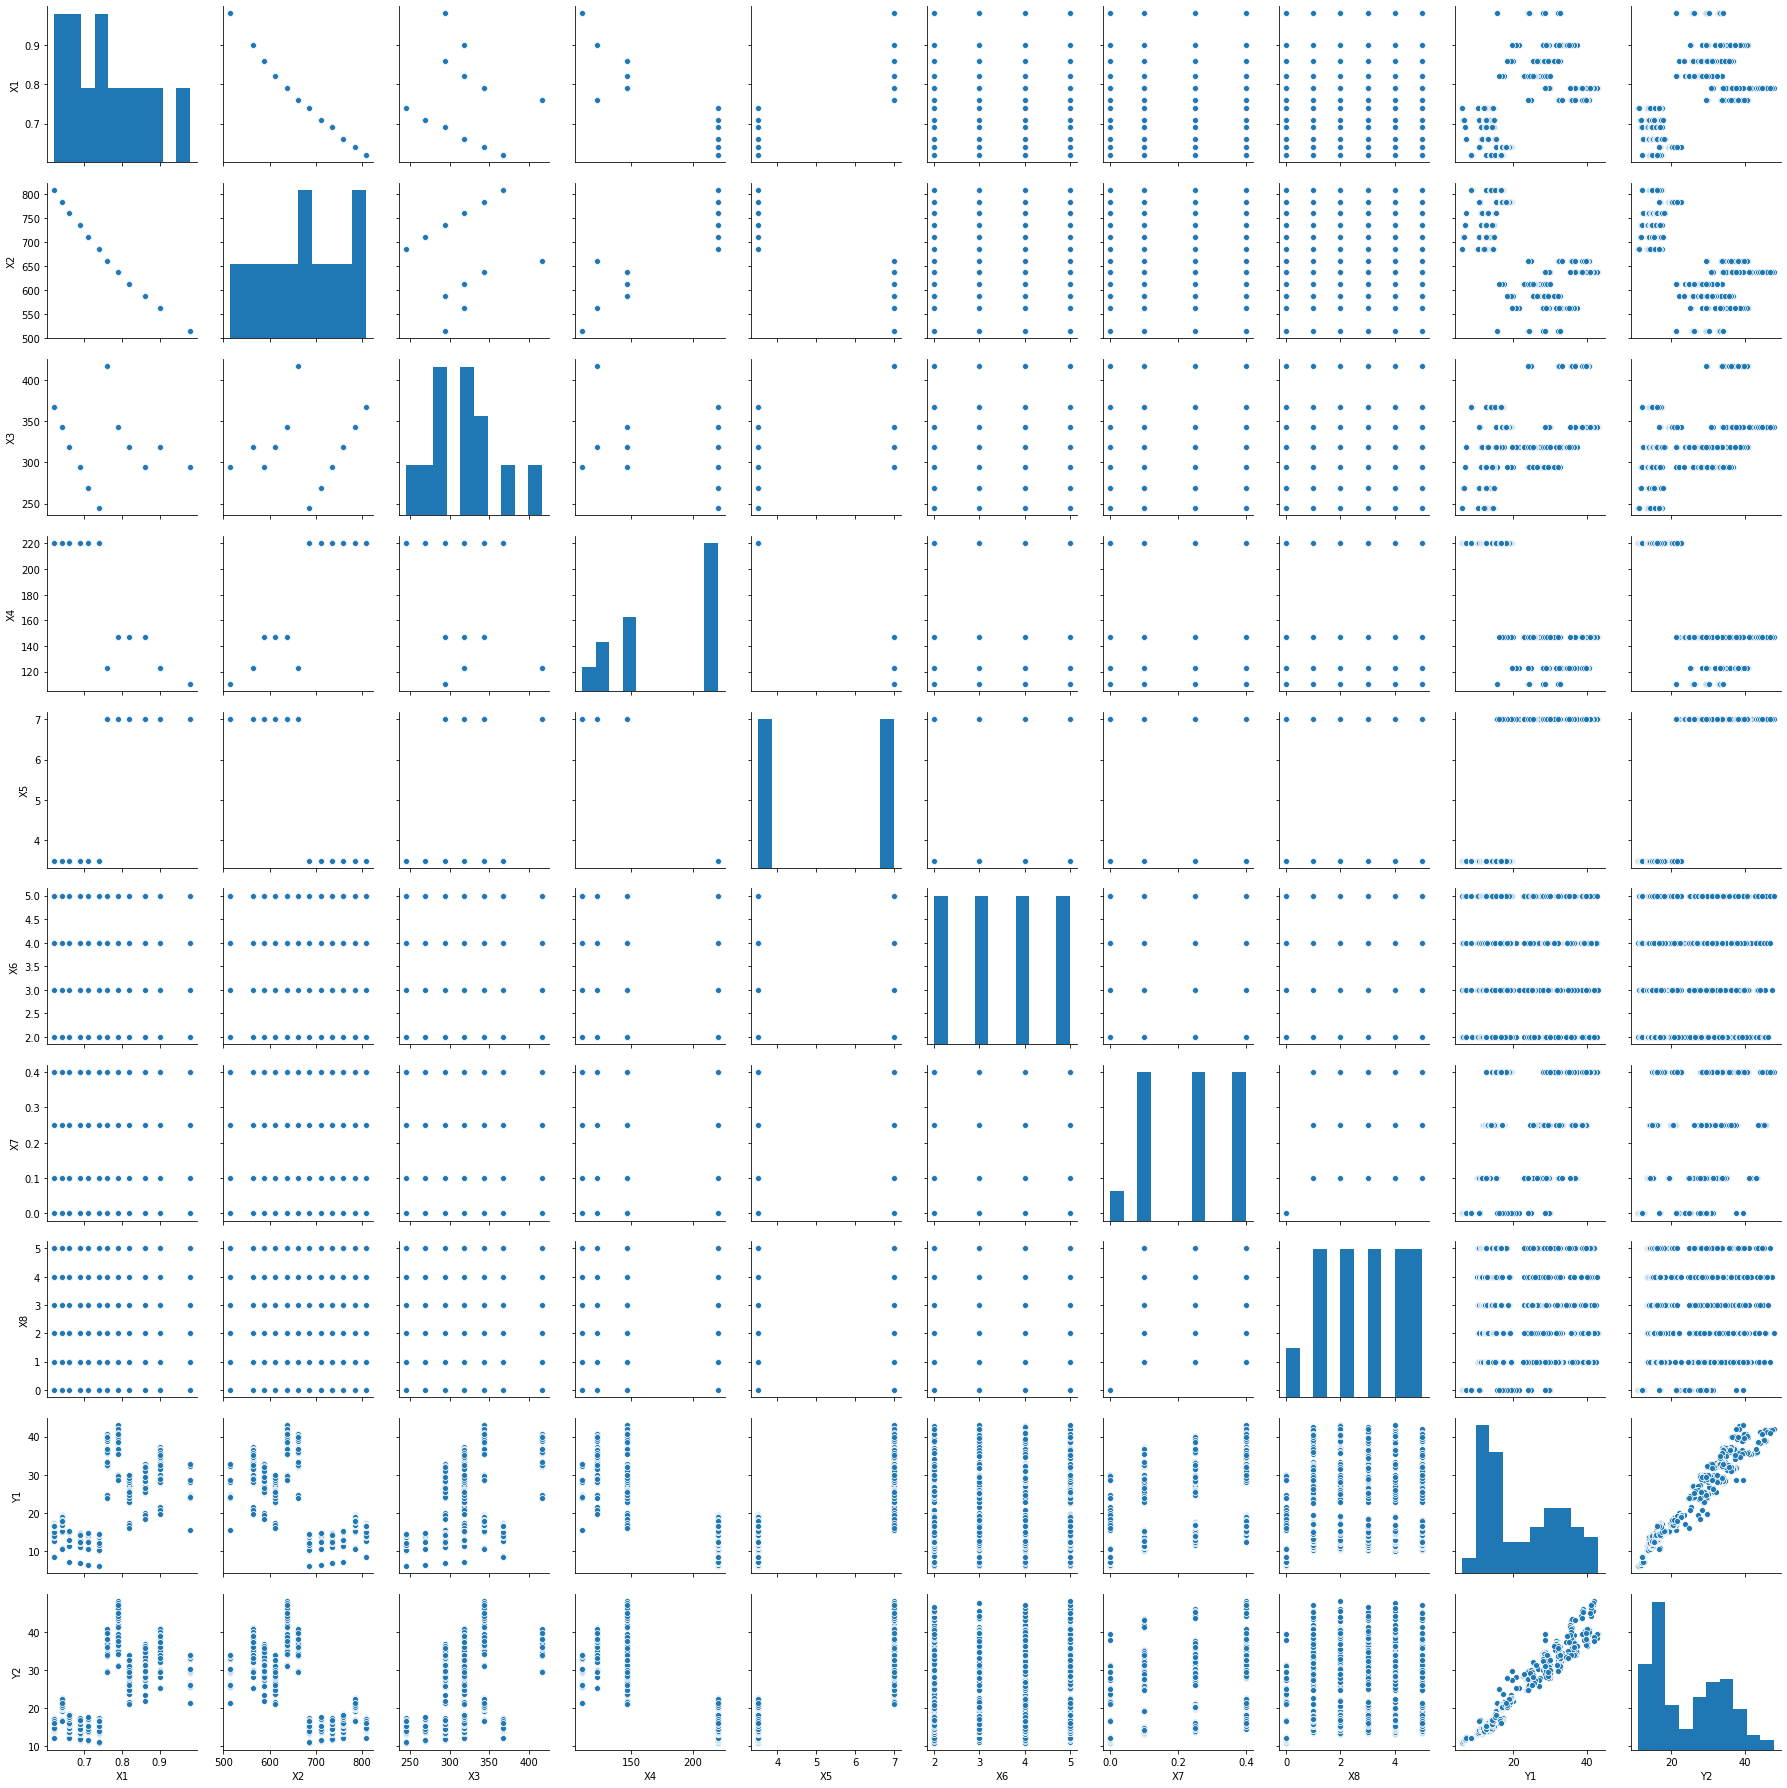

In [6]:
#let's have a look at the data and their correlations, if any
sns.pairplot(data)

In [11]:
#Select only the interesting variable for the model, and remove any anomalous value (e.g."nan")
data = data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8' ,'Y1', 'Y2']]
data = data.dropna()

# Machine Learning
Here the interesting input features and output to predict for the task are selected, the data are opportunelly preprocessed (i.e. normalized), the dataset is splitted in two separate train and test subsets, each model is trained on the training data and evaluated against a test set

In [17]:
#the module needed for the modeling and data mining are imported
#Cross-Validation 
from sklearn.model_selection import train_test_split
#Data normalization
from sklearn.preprocessing   import StandardScaler
#metrics to evaluate the model
from sklearn.metrics import mean_squared_error

In [18]:
#Selection of feature and output variable, definition of the size (fraction of the total) of the random selected test set
input_features = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
output         = ['Y1']
test_size      = 0.33
random_state   = 0

In [19]:
#not preprocessed data
unnormalized_X,unnormalized_y = data[input_features],data[output]

In [20]:
# normalisation
#Having features on a similar scale can help the model converge more quickly towards the minimum
scaler_X = StandardScaler().fit(unnormalized_X)
scaler_y = StandardScaler().fit(unnormalized_y)
X = scaler_X.transform(unnormalized_X)
y = scaler_y.transform(unnormalized_y)

In [21]:
#check if nan are present on the data after normalization to avoid trouble later
sum(np.isnan(X))

array([0, 0, 0, 0, 0, 0, 0, 0])

In [22]:
# basic train-test dataset random split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=test_size,
                                                    random_state=random_state)

In [132]:
#dictionary to help the display of the results
Score_Dict = {}

#function introduced to simplifies the following comparison and test of the various
#return the trained model and the score of the selected metrics
def fit_predict_plot(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train.ravel())

    pred_normalized_y_test = model.predict(X_test)
    pred_y_test            = scaler_y.inverse_transform(pred_normalized_y_test)
    real_y_test            = scaler_y.inverse_transform(y_test)

    mse_score = mean_squared_error(real_y_test,pred_y_test)
    
    model_name = type(model).__name__
    if(model_name=='GridSearchCV'):
        model_name ='CV_'+type(model.estimator).__name__
    
    Score_Dict[model_name]=mse_score

    plt.figure(figsize=[5,5])
    plt.scatter(real_y_test,pred_y_test)
    plt.plot([real_y_test.min(),real_y_test.max()],[real_y_test.min(),real_y_test.max()],'k:')
    plt.axis('equal')
    plt.title("Mean Squared Error: {:.2f}".format(mse_score))
    plt.xlabel('Real Heating Load')
    plt.ylabel('Predicted Heating Load')
    
    return model,mse_score



## Linear models
Used linear models in this example are:
<ul>
    <li><a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">Linear Regression</a></li>
    <li><a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html">Lasso</a></li>
    <li><a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html">Ridge</a></li>
</ul>

In [133]:
#Import the module that allows to access the Linear Regression, Lasso and Ridge algorithm
from sklearn import linear_model

[-0.59027331 -0.32320016  0.09276907 -0.35996845  0.71542956 -0.01371795
  0.25749986  0.0290825 ]
0.0008204510207815039


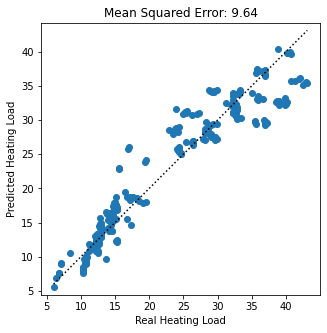

In [134]:
#initialization, fit and evaluation of the model
model = linear_model.LinearRegression()
basic_linear_model, basic_linear_score = fit_predict_plot(model,X_train,y_train,X_test,y_test)

#check the output of the model
print(basic_linear_model.coef_)
print(basic_linear_model.intercept_)



# Ridge
For advanced algorithms, hyper-parameters need to be specified, they influence the convergence and the results of the model.  

In [135]:
# Regularization strength hyper-parameter; must be a positive float
alpha = 10

[-0.20897863 -0.13046034  0.18377997 -0.21597484  0.66837016 -0.01513626
  0.25383083  0.02933132]


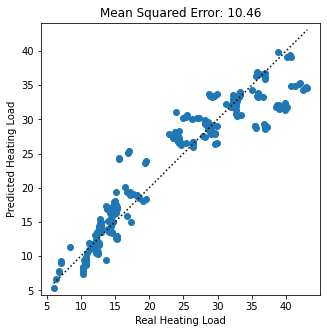

In [136]:
#initialization, fit and evaluation of the model
model = linear_model.Ridge(alpha=alpha)
ridge_model, ridge_score = fit_predict_plot(model,X_train,y_train,X_test,y_test)

#check the output of the model
print(linear_ridge_model.coef_)

# Lasso


In [137]:
# hyperparametr: alpha = 0 is equivalent to an ordinary least square, solved by the LinearRegression
alpha = 0.1

[ 0.         -0.          0.14580579 -0.          0.74346546 -0.
  0.16888611  0.        ]


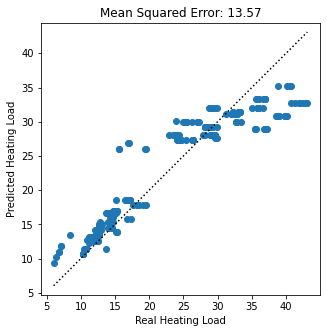

In [138]:

model = linear_model.Lasso(alpha=alpha)
lasso_model,lasso_score = fit_predict_plot(model,X_train,y_train,X_test,y_test)

print(linear_lasso_model.coef_)

# Kernel ridge
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html">Kernel ridge regression (KRR)</a> combines ridge regression with the kernel trick.

In [139]:
from sklearn.kernel_ridge import KernelRidge

In [140]:
# regularization hyper-parameter
alpha  = 0.01
kernel = 'rbf'#'polynomial'

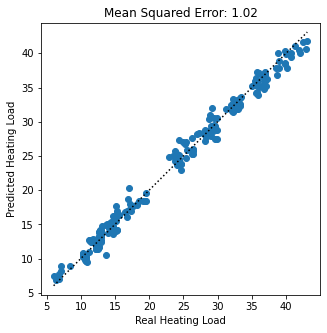

In [141]:
model = KernelRidge(alpha=alpha,kernel = kernel)
krr_model,krr_score = fit_predict_plot(model,X_train,y_train,X_test,y_test)

# Support Vector Machines
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html">Epsilon-Support Vector Regression</a>

In [142]:
from sklearn.svm import SVR

In [143]:
# hyper-parameter
C = 100
kernel='rbf'

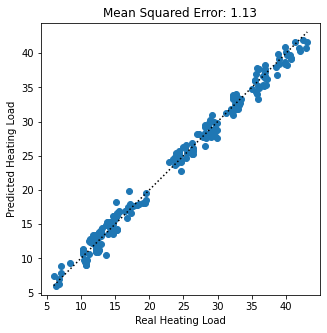

In [144]:
model = SVR(C=C,kernel=kernel,gamma='auto')
svr_model,svr_score = fit_predict_plot(model,X_train,y_train,X_test,y_test)

# Random Forest
A <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html">Random Forest Regressor</a> is a meta estimator that fits a number of classifying decision trees.

In [145]:
from sklearn.ensemble import RandomForestRegressor

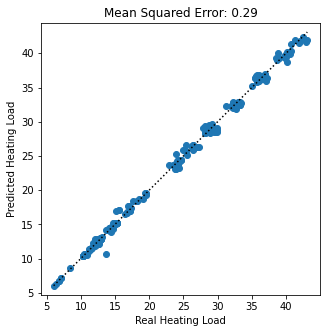

In [146]:
model = RandomForestRegressor(n_estimators=100)
random_forest_model,random_forest_score = fit_predict_plot(model,X_train,y_train,X_test,y_test)

# Hyper parameters tuning and Cross Validation
Finding the best hyperparameter of interest without writing hundreds of lines of code is an important efficiency gain
<br/>CV is to avoid bias in the performance evaluation
<br/>
For the Tuning a <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">Grid Search with Cross Validation</a> is used. <br />
<code>cv :: Determines the cross-validation splitting strategy.</code>

In [147]:
from sklearn.model_selection import GridSearchCV
#Five fold splitting strategy
cv = 5

## Lasso with GridSearchCV

{'alpha': 0.01}


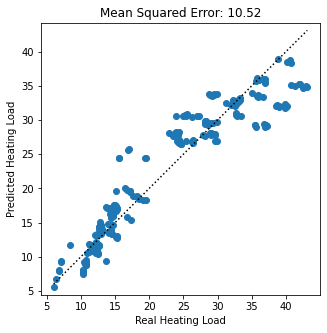

In [148]:
estimator  = linear_model.Lasso()
parameters = {'alpha':np.logspace(-2,2,5)}
model = GridSearchCV(estimator, parameters,cv=cv)

cv_lasso_model,cv_lasso_linear_score = fit_predict_plot(model,X_train,y_train,X_test,y_test)
#print the tuned hyper-parameters
print(cv_lasso_model.best_params_)

## Ridge with GridSearchCV

{'alpha': 0.1}


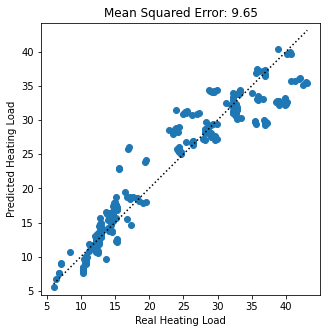

In [149]:
estimator  = linear_model.Ridge()
parameters = {'alpha':np.logspace(-2,2,5)}
model = GridSearchCV(estimator, parameters,cv=cv)

cv_ridge_model,cv_ridge_score = fit_predict_plot(model,X_train,y_train,X_test,y_test)
print(cv_ridge_model.best_params_)

## KernelRidge with GridSearchCV

{'alpha': 0.01, 'degree': 4, 'kernel': 'polynomial'}


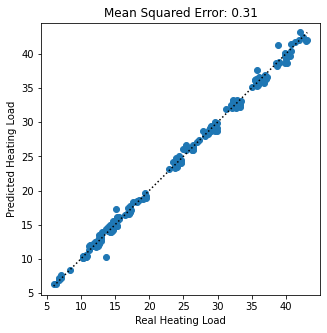

In [150]:
estimator  = KernelRidge()
parameters = {'kernel':['polynomial','rbf'],
              'degree':np.arange(10),
              'alpha':np.logspace(-2,2,5)}
model = GridSearchCV(estimator, parameters,cv=cv)

cv_krr_model,cv_krr_score = fit_predict_plot(model,X_train,y_train,X_test,y_test)
print(cv_krr_model.best_params_)

## Epsilon-Support Vector Regression with GridSearchCV

{'C': 100.0, 'kernel': 'rbf'}


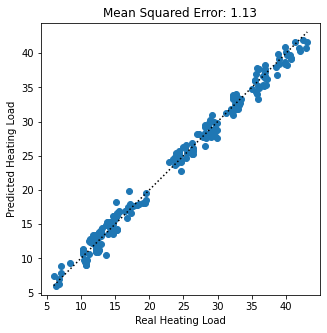

In [151]:
estimator  = SVR(gamma='auto')
parameters = {'kernel':['rbf'],
              'C':np.logspace(-2,2,5)}
model = GridSearchCV(estimator, parameters,cv=cv)

cv_svr_model,cv_svr_score = fit_predict_plot(model,X_train,y_train,X_test,y_test)
print(cv_svr_model.best_params_)

## Random Forest Regressor with GridSearchCV

{'n_estimators': 1000}


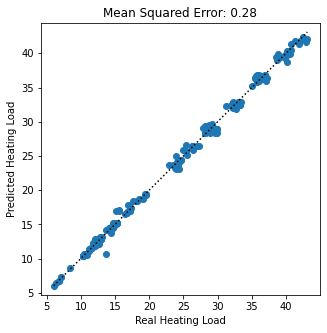

In [152]:
estimator  = RandomForestRegressor()
parameters = {'n_estimators':[10,100,1000]}
model = GridSearchCV(estimator, parameters,cv=cv)

cv_rf_model,cv_rf_score = fit_predict_plot(model,X_train,y_train,X_test,y_test)
print(cv_rf_model.best_params_)

<table><tr><th> Model</th><th> Accuracy</th></tr><tr> <td>LinearRegression</td><td>9.64</td></tr><tr> <td>Ridge</td><td>10.46</td></tr><tr> <td>Lasso</td><td>13.57</td></tr><tr> <td>KernelRidge</td><td>1.02</td></tr><tr> <td>SVR</td><td>1.13</td></tr><tr> <td>RandomForestRegressor</td><td>0.29</td></tr><tr> <td>CV_Lasso</td><td>10.52</td></tr><tr> <td>CV_Ridge</td><td>9.65</td></tr><tr> <td>CV_KernelRidge</td><td>0.31</td></tr><tr> <td>CV_SVR</td><td>1.13</td></tr><tr> <td>CV_RandomForestRegressor</td><td>0.28</td></tr></table>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 <a list of 11 Text major ticklabel objects>)

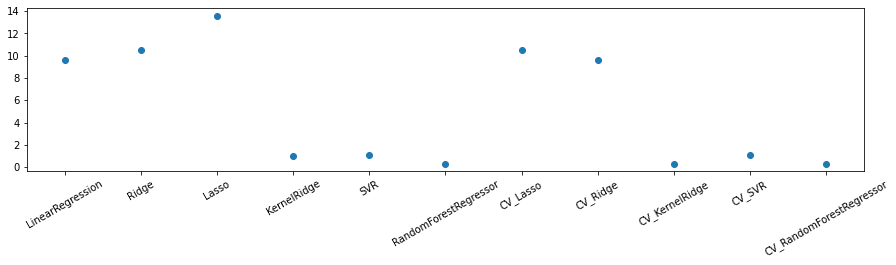

In [157]:
#print out the results in a table
from IPython.display import Markdown as md
from IPython.display import display


table = '<table><tr><th> Model</th><th> Accuracy</th></tr>'

for key, value in Score_Dict.items():
    table +='<tr> <td>'+key+'</td><td>' +'%.2f'%(value)+'</td></tr>'
table+='</table>'
display(md(table))


names = list(Score_Dict.keys())
values = list(Score_Dict.values())

plt.figure(figsize=(15, 3))
plt.scatter(names, values)
plt.xticks(rotation=30)
#fig.suptitle('Categorical Plotting')
